In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 69106276  Analysis (PULS, probably DSCT)


## TESS Data

primarily for epoch / period (amplitude: TBD)

In [2]:
tic = 69106276

sr_all = lk.search_lightcurve(f"TIC{tic}", mission="TESS")  # author="SPOC", cadence="short"
display(sr_all)
sr = sr_all
# sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])
sr = sr[sr.exptime == 20 * u.s]


astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

lcc_tess = sr.download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 92,2025,SPOC,20,69106276,0.0,N/A
1,TESS Sector 92,2025,SPOC,120,69106276,0.0,N/A


#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 92,2025,SPOC,20,69106276,0.0,N/A


LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 69106276" SECTOR=92 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

In [3]:
# List of all TCEs of the TIC
display(HTML(lket.get_tic_meta_in_html(tic, download_dir=lk_download_dir)))

RS (in R☉),3.690
MS (in M☉),1.367
Magnitude (TESS),8.00
T_eff (in K),6576.0


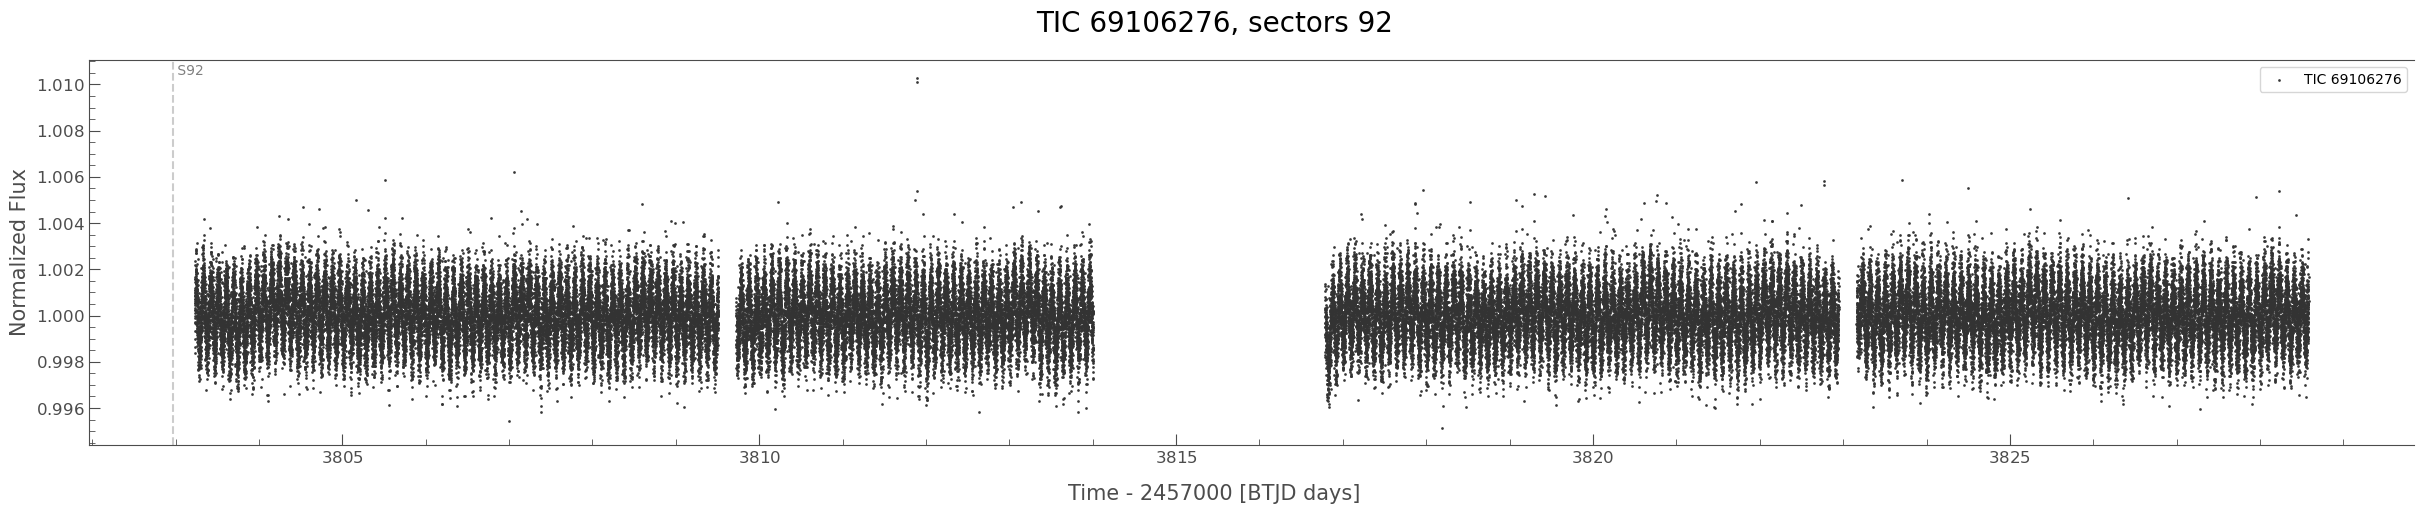

In [6]:
lc = lke.stitch(
    lcc_tess,
    ignore_incompatible_column_warning=True,    
)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=4, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);

---

## Gaia DR3 info (coordinate, etc.)

In [5]:
# reload(lke)
# reload (lket)
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic, radius_arcsec=15, magnitude_range=None,  pm_error_factor=None, pm_range_fraction=None, pm_range_minimum=None, 
                                                        calc_separation_from_first_row=True,  # assuming the first row is the target, it'd calculate more accurately the separation for Gaia DR3 Main
                                                        compact_columns=True, also_return_html=True, also_return_astrophysical=False, verbose_html=True, include_nss_summary_in_html=False)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)

In [11]:
primary_name = f"TIC {tic}"
primary_name

'TIC 69106276'

## ASAS3 data

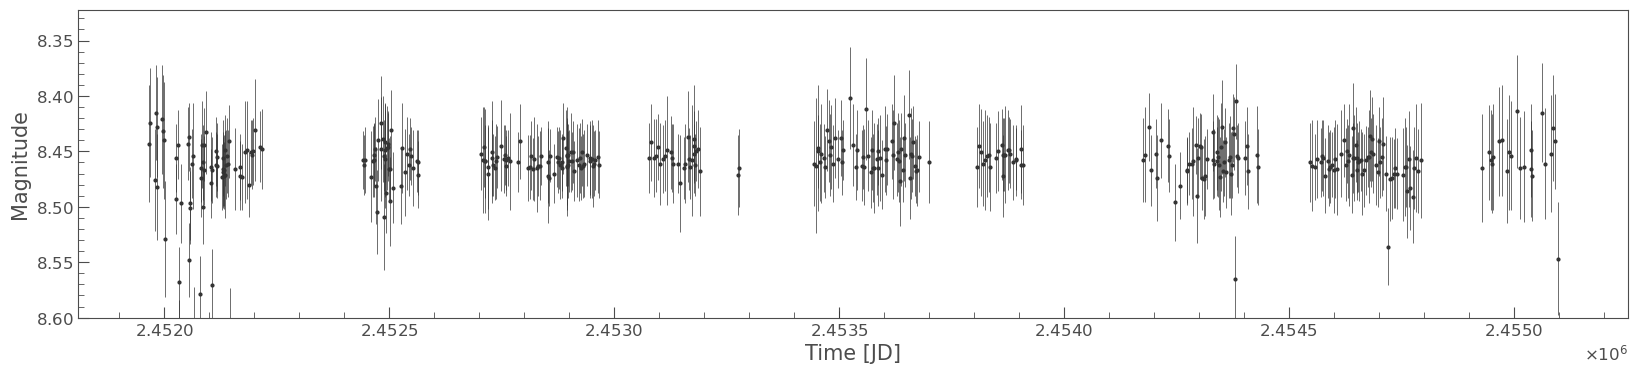

In [9]:
import lightkurve_ext_readers as lker
reload(lker)

# SkyPatrol v1 , its result has more scatter
# https://asas-sn.osu.edu/sky-patrol/coordinate/f4603ce4-bbce-4fe8-892b-4a68fae4464c
lc = (
    lker.read_asas3("http://www.astrouw.edu.pl/cgi-asas/asas_cgi_get_data?194427-2309.1,asas3")
)

ax = tplt.lk_ax(figsize=(20, 4))
ax = tplt.errorbar(lc, ax=ax);
ax.set_ylim(8.6, None);
# ax.set_title(ax.get_title());


lc_asas3 = lc  # keep the reference in a meaninfgul name for use in subsequent cells

In [ ]:
# Do not use SkyPatrol v2, the data is less reliable per Sebastián Otero
# SkyPatrol v2, g band data is as if it has been shifted to V (magnitudes comparable)
# http://asas-sn.ifa.hawaii.edu/skypatrol/objects/223338426798
#
# in SkyPatrol v1, g-band data is fainter than that of V-band
# SkyPartol v2 paper section 5 suggests g-band data begins to saturate around 12.5 mag g,
# and recommends using v1 for gmag <= 11.5
#   https://ui.adsabs.harvard.edu/abs/arXiv:2304.03791
#
# For the target here, gmag is in the saturation range, but still usable per SkyPartol v2.0 guideline
# It won't be used for magnitude / amplitude measurement so I suppose it's okay.
# lc = (
#     lker.read_asas_sn_csv(f"{lk_download_dir}/targets/tic353894340_asas_sn_skypatrol2_223338426798-light-curves.csv")
#     .select_flux("mag")
# )
# # SkyPatrol v2 data: g band seems to have been calibrated or shfited to V band
# # ax = tplt.lk_ax()
# ax2 = tplt.lk_ax(figsize=(20, 4))
# for filter, offset in zip(["V", "g" ], [0, -0.0]):
#     _lcz = lc[lc.filter == filter]  # or "g"
#     _lcz = _lcz + offset * u.mag
#     # ax = tplt.scatter(_lcz.fold(period=2.039652, epoch_time=Time(3287.5580, format="btjd").to_value("jd")), label=f"ASAS-SN {filter}", ax=ax);
#     ax2 = tplt.scatter(_lcz, label=f"ASAS-SN {filter}", ax=ax2);
# # ax.set_ylim(11.8, 11.67);
# # ax.set_ylim(11.90, 11.76);

## Combining TESS and ASAS3 data

TESS # data points: 110279
ASAS3 # data points: 437


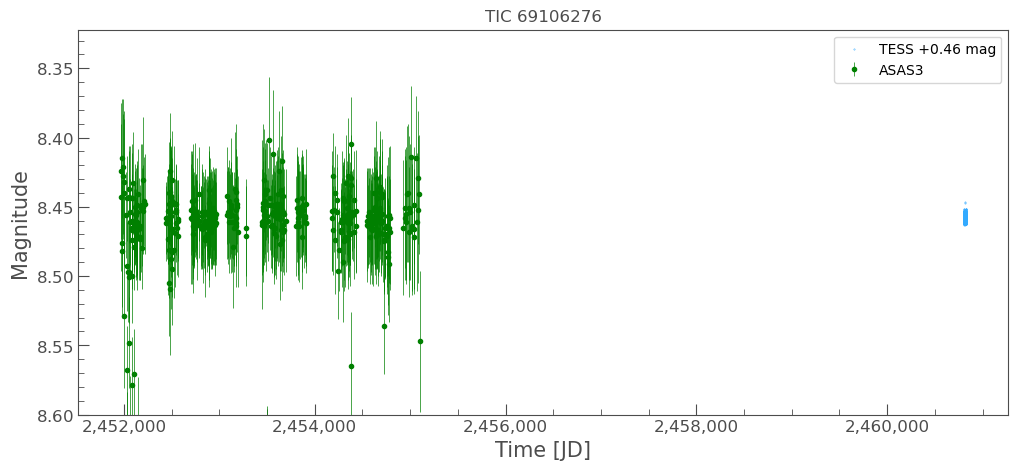

In [12]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
reload(lkem)

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True,    )

lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "ASAS3": lc_asas3,
    }, 
    shift_to="ASAS3")

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name);
ax.set_ylim(8.6, None);

## Pulsation Analysis (TESS data only)

Period at max: 0.09086010459852736 d
lightkurve.Periodogram properties:
      Attribute          Description    Units
---------------------- ---------------- -----
                nterms                1      
              targetid         69106276      
          default_view           period      
                 label     TIC 69106276      
             ls_method             fast      
frequency_at_max_power          11.0059 1 / d
             max_power           0.0012      
               nyquist        2159.8272 1 / d
   period_at_max_power           0.0909     d
             frequency array (2737564,) 1 / d
                period array (2737564,)     d
                 power array (2737564,)      
                  meta   <class 'dict'>      


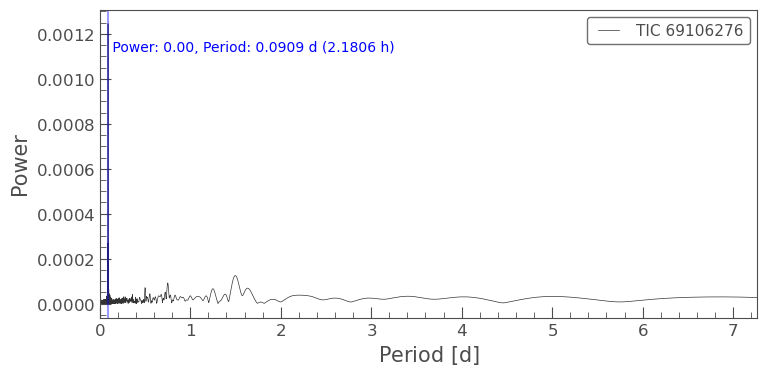

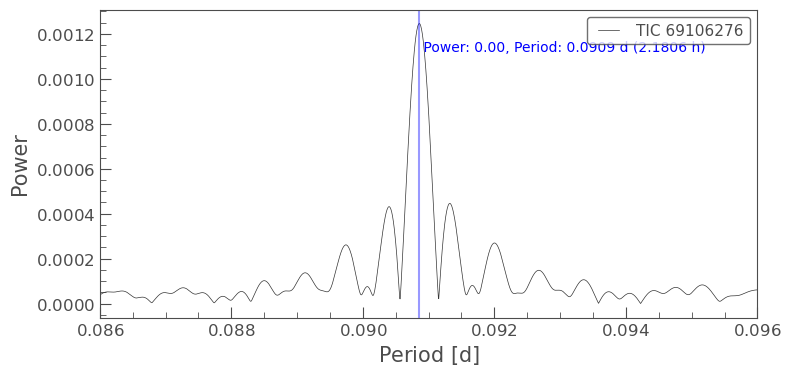

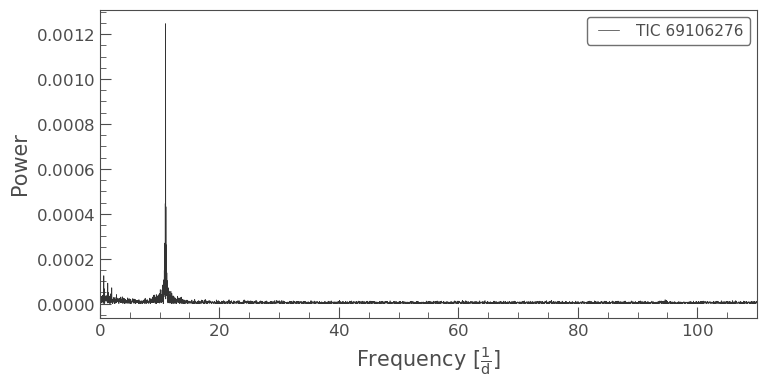

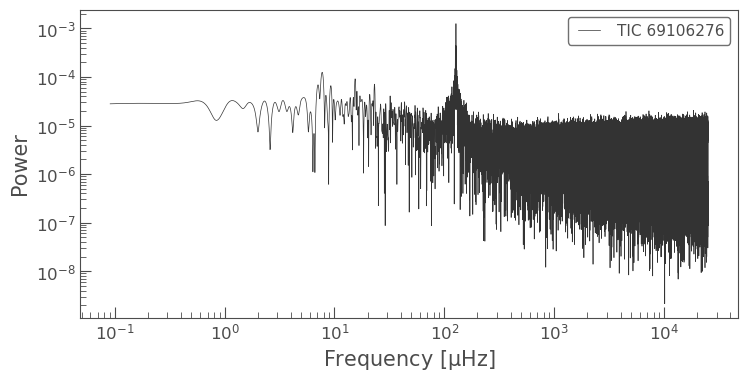

In [31]:
lc = lke.stitch(lcc_tess)  # normalized

pg = (
    lc
    .to_periodogram(method="lombscargle",
                    maximum_period=127,  # I don't really want to constrain it, but use it so that the default view is period
                    # ls_method="fastchi2", nterms=12,
                    oversample_factor=50,  # default: 5
                      )
     )
print(f"Period at max: {pg.period_at_max_power}")
pg.show_properties();

ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=80);
# ax.set_xlim(0, 16);

# zoom in
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=3);
ax.set_xlim(0.091 - 0.005, 0.091 + 0.005);

# ---

ax = pg.plot(view="frequency");  # frequency view
ax.set_xlim(0, pg.frequency_at_max_power.value * 10);

# frequency in log scale / microhertz
# often useful for solar type oscillator, 
ax = pg.plot(view="frequency", unit=u.microhertz, scale="log"); 


# frequency in log scale / microhertz
# often useful for solar type oscillator, 
# ax = pg.plot(view="frequency", unit=u.microhertz); 
# ax.set_xlim(200, 500);


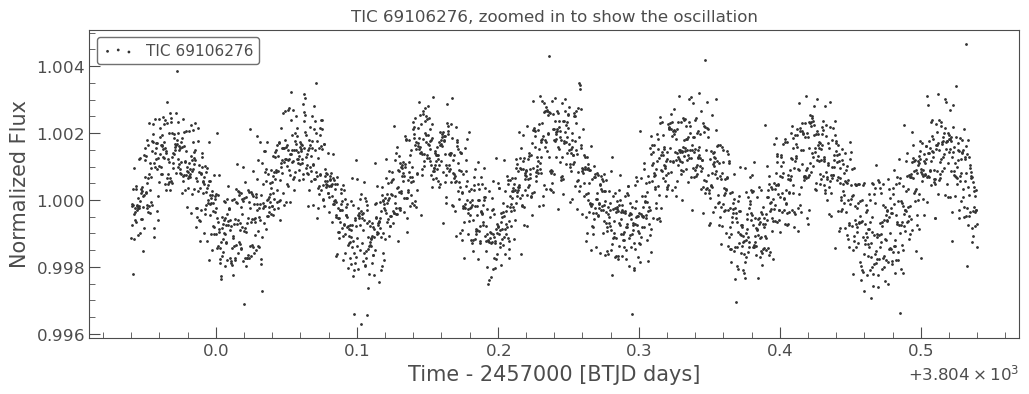

In [28]:
ax = tplt.lk_ax(figsize=(12, 4))
ax = lc.truncate(3804.240 - 0.3, 3804.240 + 0.3).scatter(ax=ax);
ax.set_title(f"{lc.label}, zoomed in to show the oscillation");

In [38]:
peaks = lke_pg.find_peaks(
    pg, 
    # pg[pg.frequency < 500 * u.microhertz], 
    # powerlimit=10**-4,   
)
if "period" not in peaks.columns:
    peaks["period"] = 1 / peaks["frequency"]
    peaks["period"].unit = 1 / peaks["frequency"].unit
if "frequency" not in peaks.columns:
    peaks["frequency"] = 1 / peaks["period"]
    peaks["frequency"].unit = 1 / peaks["period"].unit
peaks["frequency_u"] = u.Quantity(peaks["frequency"]).to(u.microhertz)  # in microhertz, for log scale plot
peaks["period_h"] = u.Quantity(peaks["period"]).to(u.hour)  # period in hours
peaks["rank"] = np.linspace(1, len(peaks), len(peaks), dtype=int)

peaks[peaks["period"] > 0][:15]


power,period,prominence,lower_hwhm,upper_hwhm,fwhm,period_ratio,frequency,frequency_u,period_h,rank
,d,,d,d,d,,1 / d,uHz,h,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
0.0,0.09086010459852736,0.0,0.00018164,-0.00018483,0.00036647,1.000,11.0059305392458,127.3834553153449,2.180642510364657,1
0.0,0.09132491305651874,0.0,0.00013978,-0.00011944,0.00025922,0.995,10.949914612906607,126.7351228345672,2.19179791335645,2
0.0,0.0904000035718051,0.0,0.00011271,-0.00013974,0.00025245,1.005,11.061946465584992,128.0317877961226,2.169600085723322,3
0.0,0.09200105114603808,0.0,0.00015501,-0.00014209,0.0002971,0.988,10.869441028588332,125.80371560866125,2.208025227504914,4
0.0,0.08974075595338918,0.0,0.00013943,-0.0001485,0.00028792,1.012,11.14320900661227,128.9723264654198,2.1537781428813405,5
0.0,1.496488979794085,0.0,0.053612,-0.046131,0.099743,0.061,0.6682307811832993,7.73415255999189,35.91573551505804,6
0.0,0.09267372193450063,0.0,0.00014379,-0.00013294,0.00027673,0.980,10.79054535768806,124.89057126953774,2.224169326428015,7
0.0,0.7508954201934366,0.0,0.01211,-0.011404,0.023514,0.121,1.3317433734545778,15.413696452020577,18.02149008464248,8


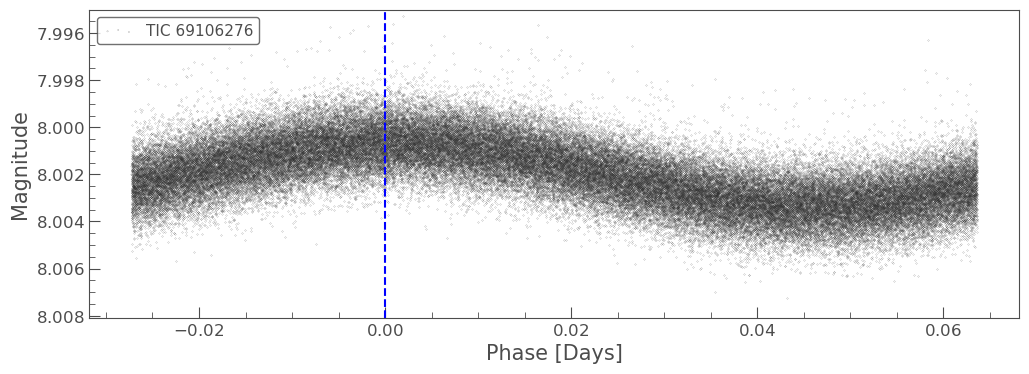

In [78]:
epoch_time_hjd = 2460804.240  # from 3804.240, manual inspection, with further manual tweak
period_final = 0.09086   # LS Periodogram, ronded

lc_f = lc_tess.fold(epoch_time=epoch_time_hjd, period=period_final, wrap_phase=period_final * 0.7 * u.d);
ax = tplt.scatter(lc_f, figsize=(12, 4), s=0.05);
ax.axvline(0, c="blue", linestyle="--");
ax.set_ylim(None, 7.995);



### Pulsation amplitude

0.003

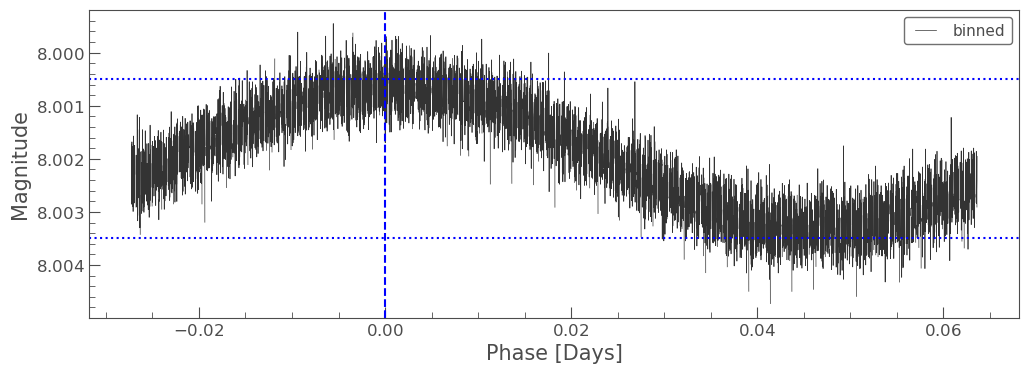

In [105]:
max_flux_mag = 8.0005 # from inspection
min_flux_mag = 8.0035 # from inspection


lc_b = lke.bin_flux(lc_tess.truncate(7.995, None, column="flux"), time_bin_size=200*u.s)
lc_f_b = lc_b.fold(epoch_time=epoch_time_hjd, period=period_final, wrap_phase=period_final * 0.7 * u.d);

ax = tplt.plot(lc_f_b, figsize=(12, 4), label="binned");
ax.axvline(0, c="blue", linestyle="--");

ax.axhline(max_flux_mag, c="blue", linestyle="dotted");
ax.axhline(min_flux_mag, c="blue", linestyle="dotted");

amp_flux_mag = round(min_flux_mag - max_flux_mag, 3)
amp_flux_mag

## Mean magnitude from ASAS3

In [101]:
mean_flux_vmag = np.nanmedian(lc_asas3.flux.value)

# see the error as well
print(mean_flux_vmag, np.nanmedian(lc_asas3.flux_err.value))

# rounded me
mean_flux_vmag = round(mean_flux_vmag, 2)
mean_flux_vmag  # Tycho2 is also 8.46

8.458 0.034


8.46

## Plots for VSX

In [58]:
# reload(lkem)
# ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name);
# ax.set_ylim(11.85, 11.65);
# ax.set_title(ax.get_title() + ", outliers truncated");

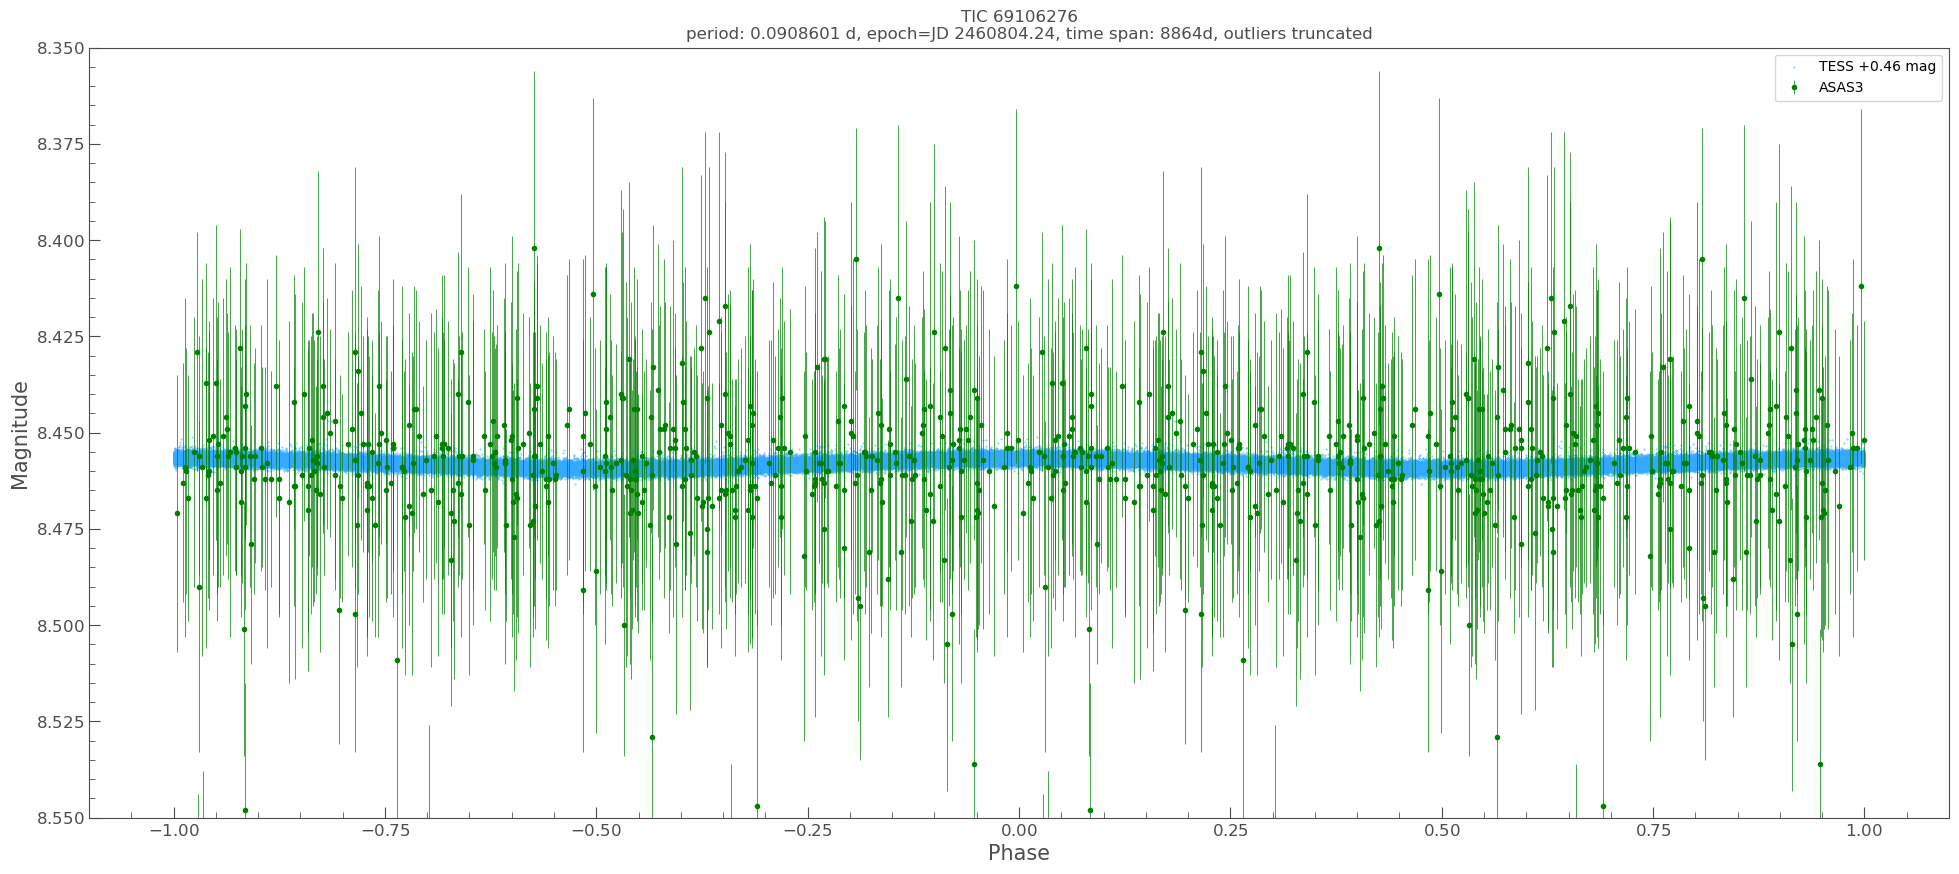

In [117]:
# reload(lkem)
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    figsize=(24, 10),
    target_name=primary_name,
);
ax.set_ylim(8.55, 8.35);
ax.set_title(ax.get_title() + ", outliers truncated");

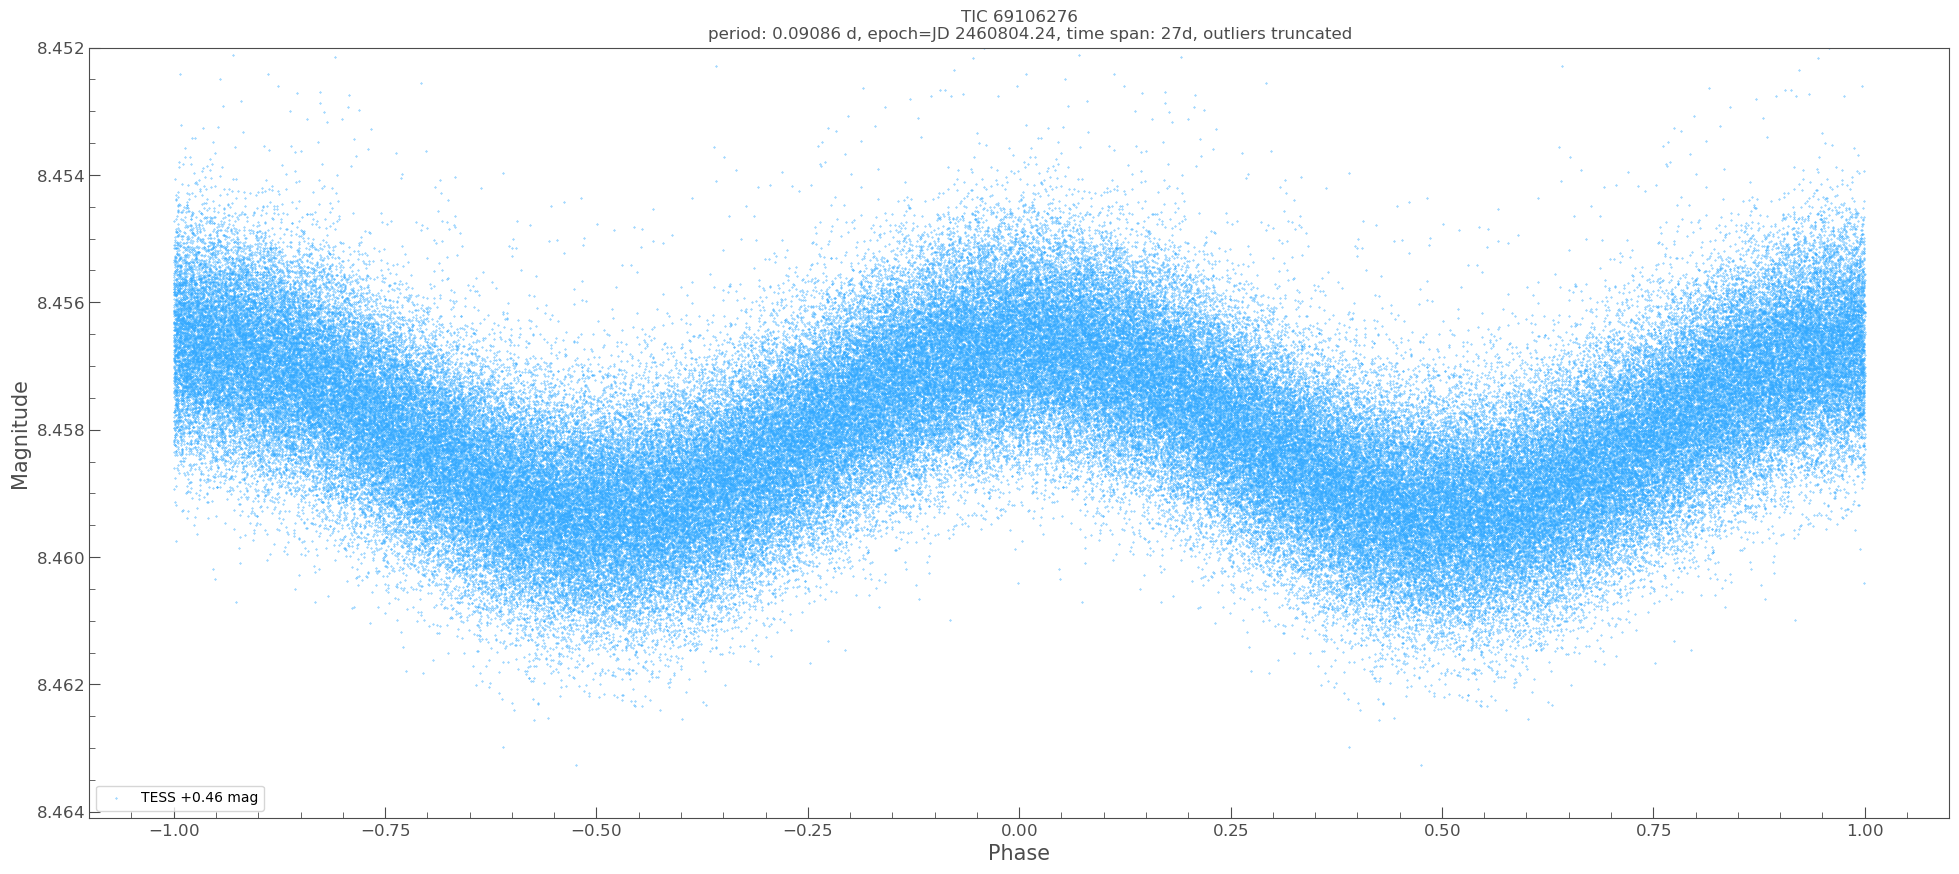

In [116]:
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    # lc_combined_dict,
    {"TESS": lc_combined_dict["TESS"]}, 
    period=period_final,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    figsize=(24, 10),
    target_name=primary_name,
);
ax.set_ylim(None, 8.4520);
ax.set_title(ax.get_title() + ", outliers truncated");

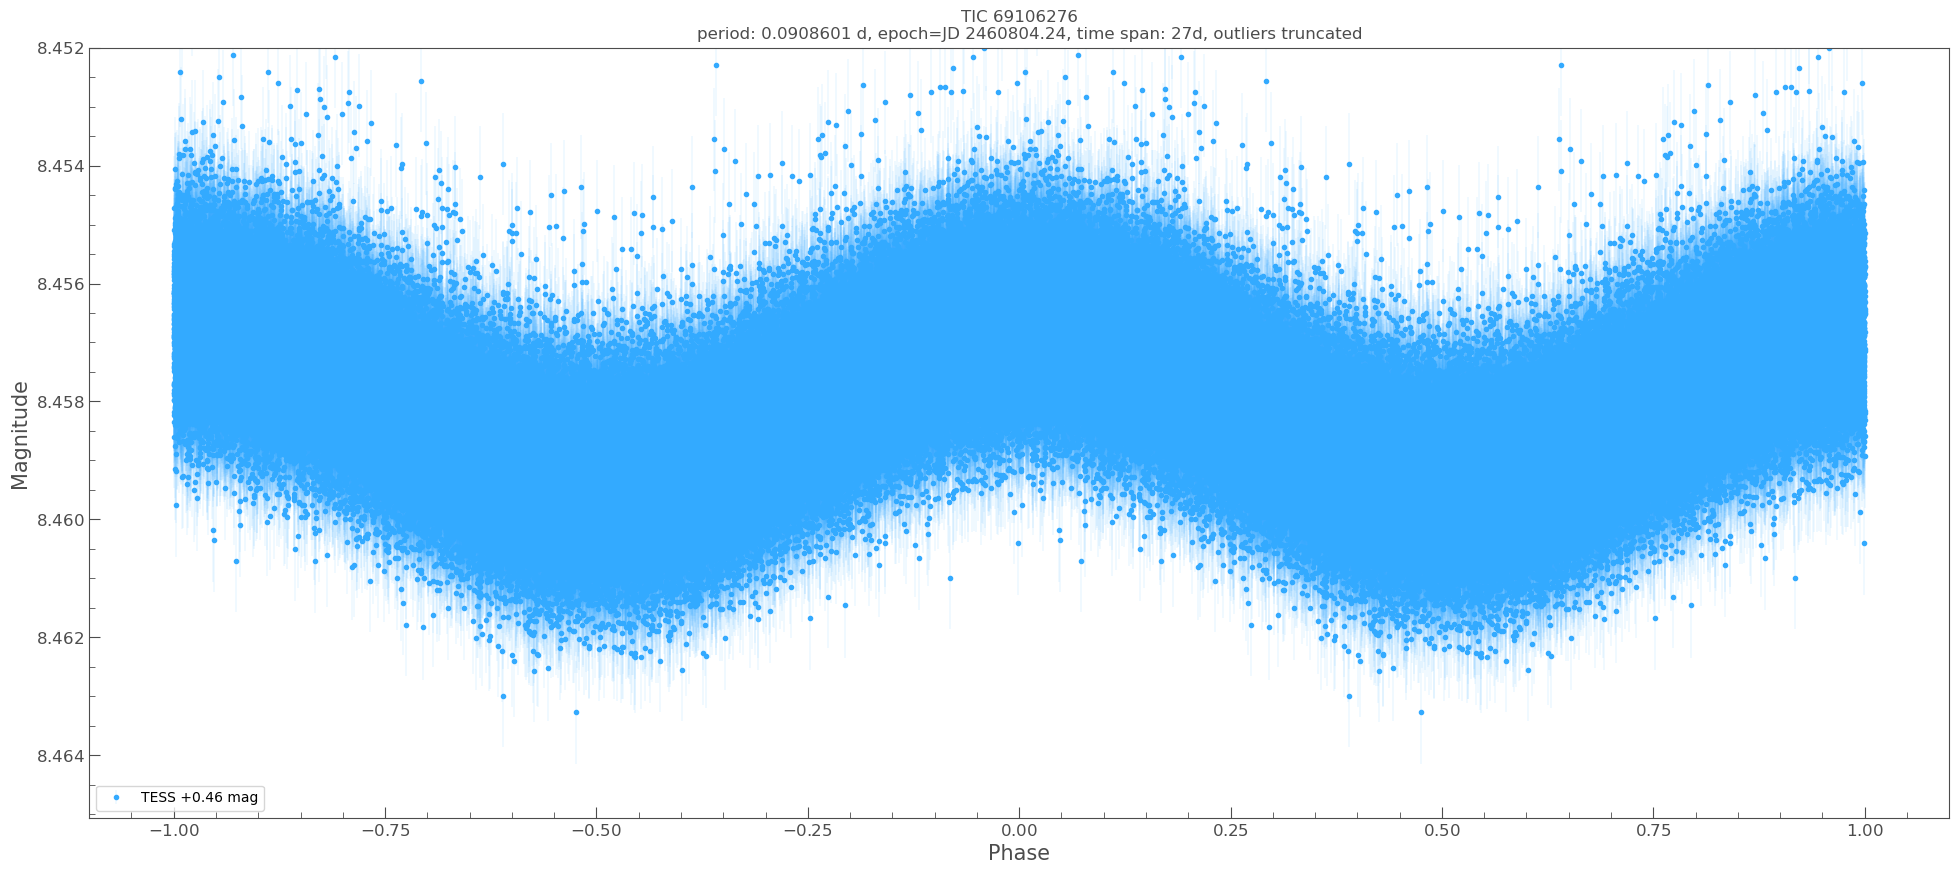

In [90]:
plot_options_tess_errorbar = lkem.get_default_plot_multi_bands_options_copy()
plot_options_tess_errorbar[0] = ('errorbar', {'marker': '.', 'c': '#3AF', 'linewidth': 0.1, 'ls': 'none'})

# to get around astropy masked TypeError: cannot write to unmasked output
_lc_t = lc_combined_dict["TESS"].copy()["time", "flux", "flux_err"]
_lc_t.flux = _lc_t.flux.filled(np.nan)
_lc_t.flux_err = _lc_t.flux_err.filled(np.nan)


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    # lc_combined_dict,
    {"TESS": _lc_t}, 
    period=period_final,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    figsize=(24, 10),
    target_name=primary_name, 
    plot_options=plot_options_tess_errorbar,
);
ax.set_ylim(None, 8.4520);
ax.set_title(ax.get_title() + ", outliers truncated");

## VSX Report Table

In [95]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

In [113]:
import bibs_utils
reload(bibs_utils)


other_names = "HD 186318,TYC 6890-1846-1,2MASS J19442698-2309040,GSC 06890-01846,CD-23 15690,CPD-23 7564,SAO 188506"  # From SIMBAD, double-checked. it has o HIP or GJ
other_names += ",WISEA J194426.98-230904.0"   # ExoFOP,  https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ6861ceed27af63&-out.add=.&-source=II/328/allwise&AllWISE===J194426.98-230904.0

# GSC: https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/255/out
# GSC serach returns GSC 0390700062 in 2 rows, indicating the GSC id matches 2 objetcs. So for now I avoid from using it
#https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ65cc1e7bc59c1&-to=-4b&-from=-3&-this=-4&%2F%2Fsource=I%2F255%2Fout&%2F%2Ftables=I%2F255%2Fout&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&-out.add=_r&%2F%2Foutaddvalue=default&-sort=_r&-order=I&-oc.form=sexa&-out.src=I%2F255%2Fout&-nav=cat%3AI%2F255%26tab%3A%7BI%2F255%2Fout%7D%26key%3Asource%3DI%2F255%2Fout%26pos%3A271.75686186442%2C+54.98630213781%28+++30+arcsec+J2000%29%26HTTPPRM%3A&-c=271.75686186442%2C+54.98630213781&-c.eq=J2000&-c.r=+30&-c.u=arcsec&-c.geom=r&-source=&-source=I%2F255%2Fout&-out=GSC&-out=RAJ2000&-out=DEJ2000&-out=PosErr&-out=Pmag&-out=e_Pmag&-out=n_Pmag&-out=Class&-out=Epoch&-meta.ucd=2&-meta=1&-meta.foot=1&-usenav=1&-bmark=GET

remarks = f""
    
revision_comment = "Type, period, epoch, amplitude from TESS data. Mean Magnitude from ASAS3 data. Spectral type from 1988mcts.book.....H . Position from Gaia DR3."

BIBS = bibs_utils.BIBS

vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="DSCT",
    Spectral_Type="F2/3V",  # https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-source=III/133/vol4&HD=186318, referenced by SIMBAD
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"{mean_flux_vmag}",
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{amp_flux_mag}",
    Minimum_Magnitude_band="TESS",  
    Minimum_Is_Amplitude=False,
    Period=f"{period_final:.3f}",
    Epoch=epoch_time_hjd,
    Discoverer="Sam Lee",
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name=BIBS.TESS_N,
    Reference0_Bib=BIBS.TESS_B,
    Reference1_Name=BIBS.ASAS3_N,
    Reference1_Bib=BIBS.ASAS3_B,
    Reference2_Name="Houk, N.; Smith-Moore, M., 1988, Michigan Catalogue of Two-dimensional Spectral Types for the HD Stars. Volume 4, Declinations -26°.0 to -12°.0.",
    Reference2_Bib="1988mcts.book.....H",
)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))

# Uploaded plots with  descriptions
print("""
tic69106276_phase_plot_pulsation.png : Pulsation Phase Plot - Pulsation Phase Plot of the target from TESS, shifted to ASAS3 V, outliers truncated.
""")


Other Names (1 line each):
HD 186318
TYC 6890-1846-1
2MASS J19442698-2309040
GSC 06890-01846
CD-23 15690
CPD-23 7564
SAO 188506
WISEA J194426.98-230904.0



Type, period, epoch, amplitude from TESS data. Mean Magnitude from ASAS3 data. Spectral type from 1988mcts.book.....H . Position from Gaia DR3.


,Field,Value
0,Position,"296.11242579495, -23.15111877688"
1,Primary_Name,TIC 69106276
2,Other_Names,"HD 186318,TYC 6890-1846-1,2MASS J19442698-2309040,GSC 06890-01846,CD-23 15690,CPD-23 7564,SAO 188506,WISEA J194426.98-230904.0"
3,Variable_Type,DSCT
4,Spectral_Type,F2/3V
5,Spectral_Type_Uncertain,False
6,Maximum_Magnitude,8.46
7,Maximum_Magnitude_band,V
8,Minimum_Magnitude,0.003
9,Minimum_Magnitude_band,TESS



tic69106276_phase_plot_pulsation.png : Pulsation Phase Plot - Pulsation Phase Plot of the target from TESS, shifted to ASAS3 V, outliers truncated.



# Scratch